# Visualizing the results

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import geopandas as gpd
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


In [2]:
ds_path = '../../../results/batch/run_ds.nc'
ds = xr.open_dataset(ds_path)

c:\Users\gabriel.genelot\AppData\Local\Programs\Python\Python312\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [16]:
variables = ['define_tot_eq_define_total_impact',
       'dice_tot_eq_dice_total_impact',   
       'witness_tot_eq_witness_total_impact']

#        'fund_tot_eq_monetary_impact', removed FUND because otherwise we couldn't read the other models

df = ds[variables].to_dataframe().reset_index()
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

df

,Run,time,REGIONS 35 I,define_tot_eq_define_total_impact,dice_tot_eq_dice_total_impact,witness_tot_eq_witness_total_impact
1,0,2005.0,BELGIUM,775.321254,936.589426,1.582538e+03
2,0,2005.0,BULGARIA,171.906451,207.663293,3.508848e+02
3,0,2005.0,CROATIA,136.193829,164.522383,2.779904e+02
4,0,2005.0,CYPRUS,41.889519,50.602612,8.550230e+01
5,0,2005.0,CZECH REPUBLIC,457.043231,552.109020,9.328884e+02
...,...,...,...,...,...,...
4825,2,2050.0,INDIA,615470.138807,544122.644461,9.302668e+05
4826,2,2050.0,LATAM,332048.250369,293556.032515,5.018821e+05
4827,2,2050.0,RUSSIA,79934.700144,70668.384515,1.208192e+05
4828,2,2050.0,USMCA,989233.968727,874558.437714,1.495201e+06


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

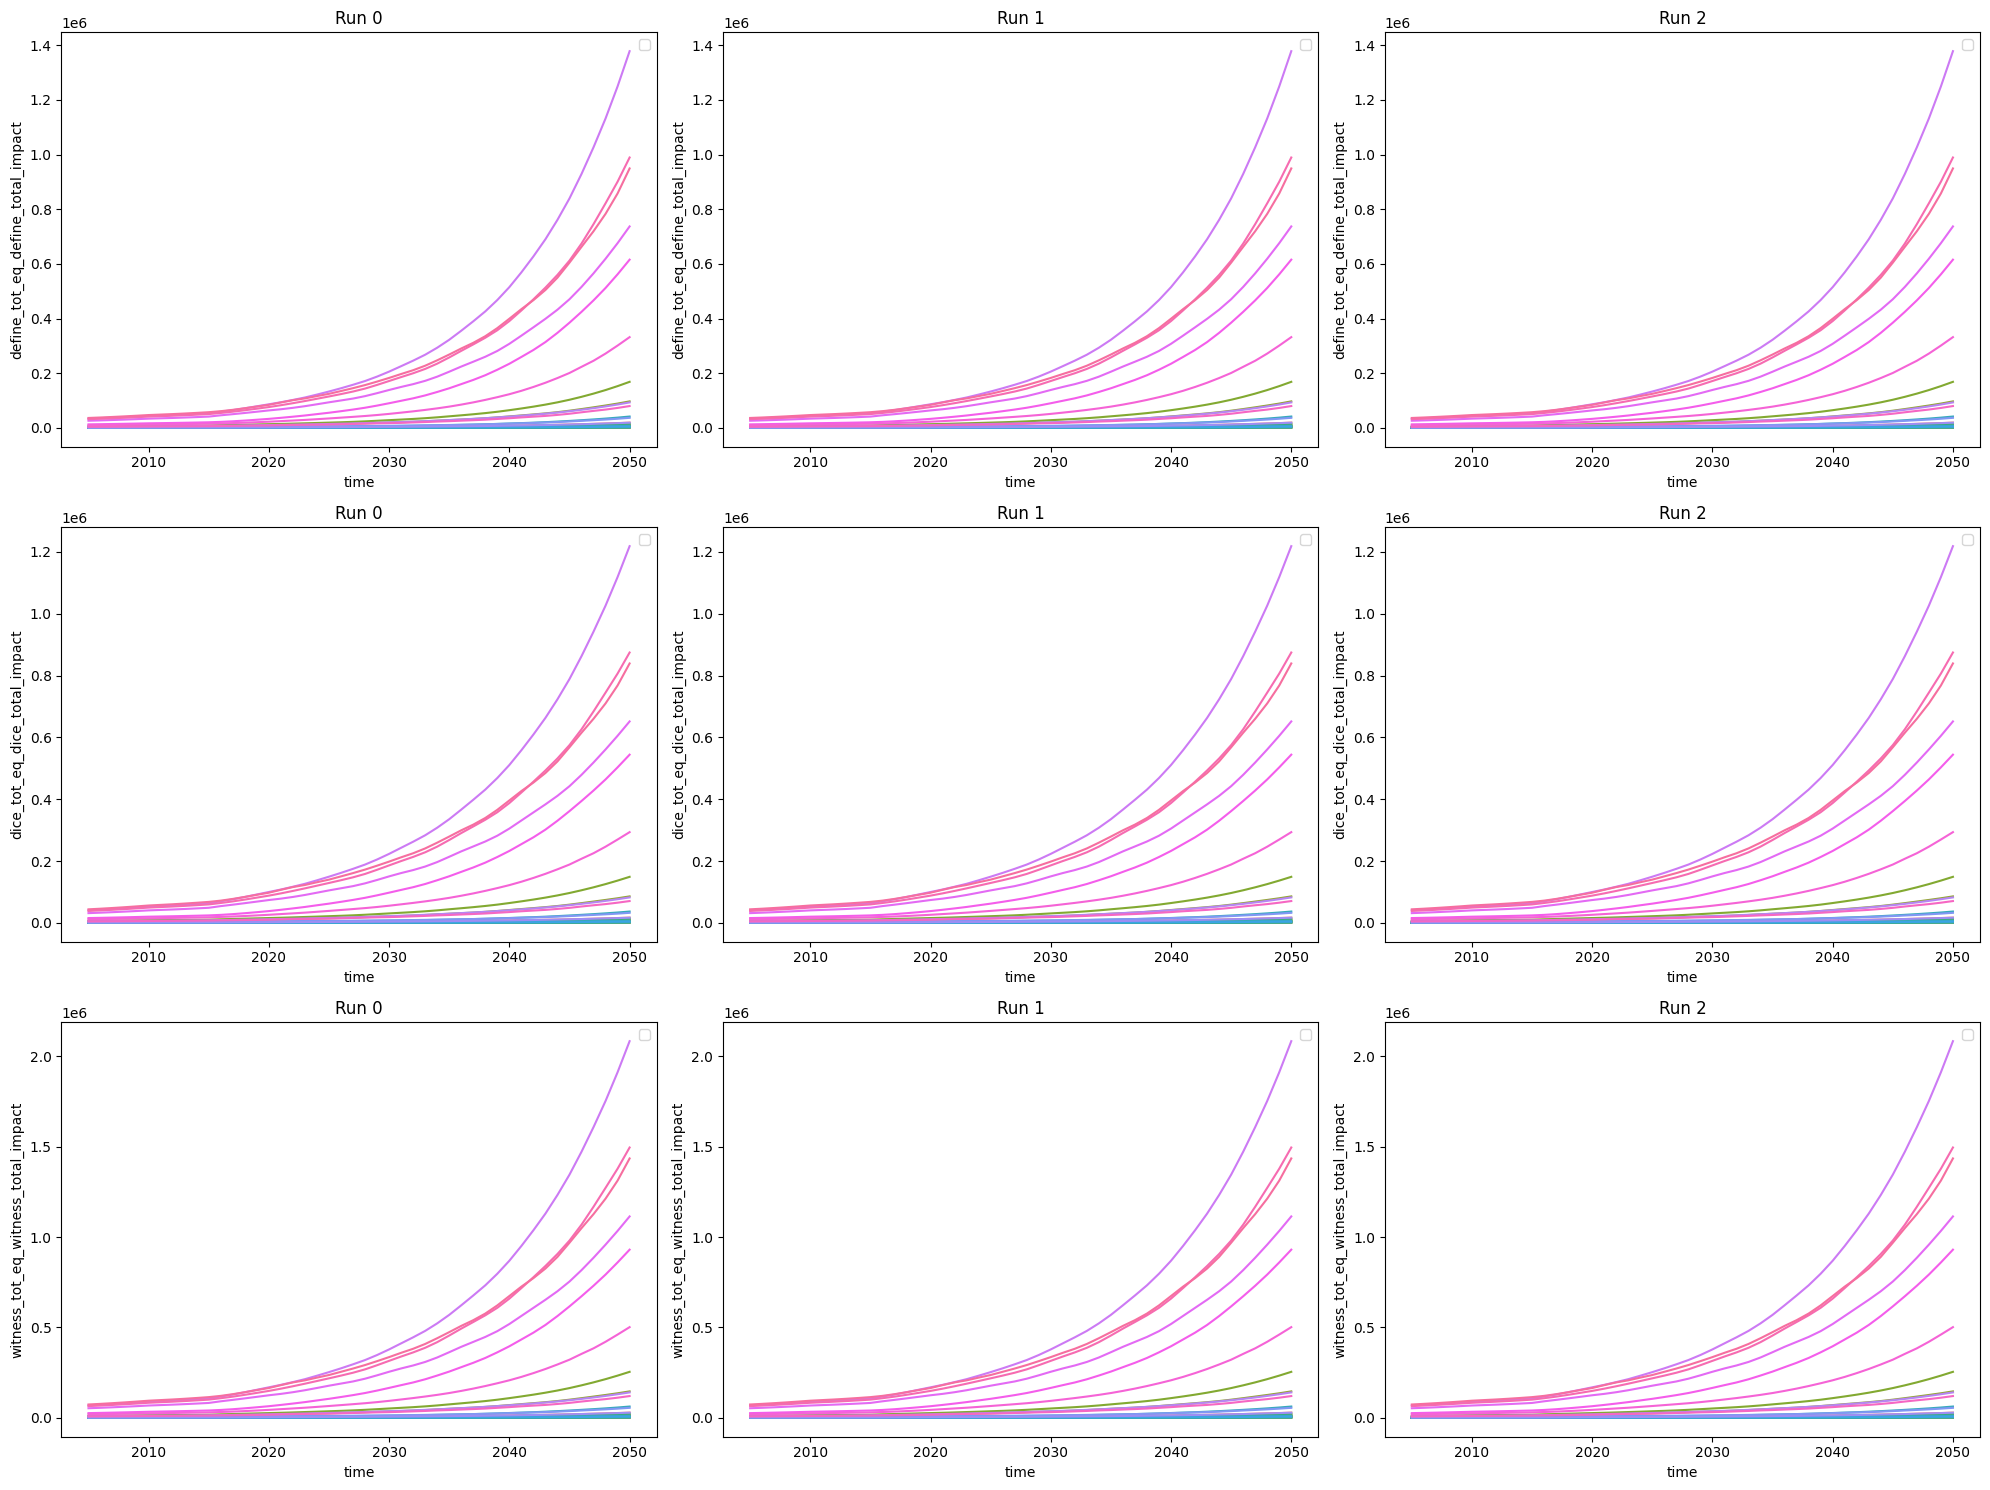

In [14]:
run = df['Run'].unique()

fig, ax = plt.subplots(len(variables), len(run), figsize=(20, 15))

for j, r in enumerate(run):
    for i, v in enumerate(variables):
        sns.lineplot(data=df[df['Run'] == r], x='time', hue='REGIONS 35 I', y=v, ax=ax[i, j], legend=False)
        ax[i, j].set_title(f'Run {r}')
        ax[i, j].set_ylabel(v)
        ax[i, j].legend()

plt.tight_layout()  
plt.show()

Let's map ! 

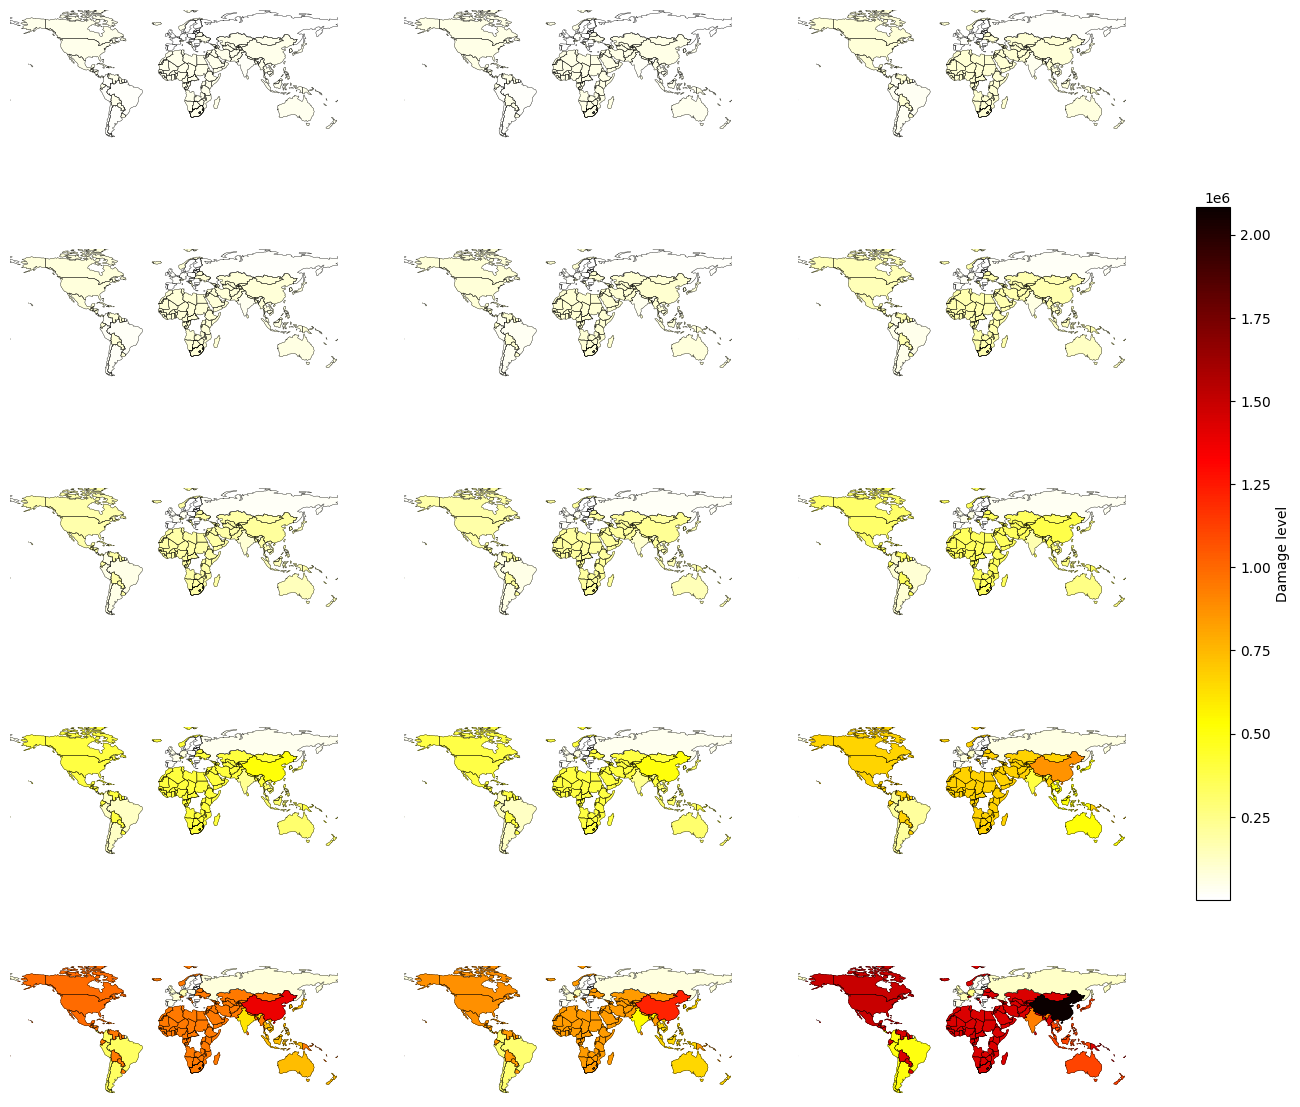

In [36]:
decades = np.arange(2010, 2051, 10)

fig, ax = plt.subplots(len(decades), len(variables), figsize=(18, 15))

map = gpd.read_file(r'../../../WILIAM\geography\output_countries\countries.shp')

vmin = df[variables].values.min()
vmax = df[variables].values.max()


for j, r in enumerate(variables):
    for i, d in enumerate(decades):
        map_variable = map.merge(df[df['time'] == d], left_on='REGIONS 35', right_on='REGIONS 35 I')

        ax[i, j].set_axis_off()
        ax[i, j].set_xlim(-180, 180)
        ax[i, j].set_ylim(-60, 80)

        map_variable.boundary.plot(ax=ax[i, j], linewidth=0.2, color='black', alpha=0.5)
        map_variable.plot(column=r, ax= ax[i,j], cmap='hot_r', vmin=vmin, vmax=vmax)

        if j == 0:
            ax[i, j].set_ylabel(f'{d}', fontsize=12)
        
# Créer un objet Normalize pour normaliser les valeurs dans [vmin, vmax] à [0, 1]
norm = Normalize(vmin=vmin, vmax=vmax)

# Créer une ScalarMappable pour mapper les valeurs normalisées à une colormap
sm = ScalarMappable(cmap='hot_r', norm=norm)
sm.set_array([])  # Mettre un tableau vide, les données ne sont pas encore nécessaires

# Ajout d'une colorbar commune pour toutes les sous-graphiques
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.6)
cbar.set_label('Damage level')  # Définir le label de la colorbar

#plt.tight_layout()

plt.savefig('../../../figures/output.png')
